In [215]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [216]:
def binarize_stripes(stripes_raw, verbose=False):
    stripes_gray = cv2.cvtColor(stripes_raw, cv2.COLOR_BGR2GRAY)
    stripes_blured = cv2.GaussianBlur(stripes_gray, (5, 5), 0)
    _, stripes_binarized = cv2.threshold(stripes_blured, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    if verbose:
        plt.imshow(stripes_binarized, 'grey')
        plt.show()
    return stripes_binarized

def find_n_contours(stripes_binarized, stripes_raw, n=3, verbose=False):
    contours, _ = cv2.findContours(stripes_binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    if verbose:
        stripes_raw_copy = deepcopy(stripes_raw)
        stripes_raw_copy = cv2.cvtColor(stripes_raw_copy, cv2.COLOR_BGR2RGB)
        rectangle_size = 20
        for contour in contours_sorted[:n]:
            M = cv2.moments(contour)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            cv2.drawContours(stripes_raw_copy, [contour], -1, (200, 0, 0), 2)
            cv2.circle(stripes_raw_copy, (cx, cy), 5, (0, 160, 0), -1)
            cv2.rectangle(stripes_raw_copy, (cx-rectangle_size, cy-rectangle_size), (cx+rectangle_size, cy+rectangle_size), (0, 0, 160))

        plt.imshow(stripes_raw_copy)
        plt.show()
    return contours_sorted[:n]

In [217]:
def label_contours(stripes_raw, contours):
    valued_contours = []
    for contour in contours:
        M = cv2.moments(contour)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        mean = np.mean(stripes_raw[cy-10: cy+10, cx-10: cx+10])
      
        black_canvas = np.zeros_like(stripes_raw).astype(np.uint8)
        cv2.drawContours(black_canvas, [contour], -1, (255,255,255), cv2.FILLED)
        var = np.var(stripes_raw[black_canvas == 255])
        
        valued_contours.append((contour, mean, var))


    valued_contours = sorted(valued_contours, key=lambda x: x[2], reverse=True)
    result = {'sample': valued_contours[0][0]}
    if len(valued_contours) > 1:
        valued_contours = sorted(valued_contours[1:], key=lambda x: x[1], reverse=True)
        result['control'] = valued_contours[0][0]
        result['max_dose'] = valued_contours[1][0]
    
    return result

In [218]:
def find_maximal_inscribed_rectangle(bin, contour):
    mask = np.zeros_like(bin).astype(np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, -1)  # Fill the contour

    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    # Find the maximum inscribed rectangle
    max_area = 0
    best_rect = None
    h, w = dist_transform.shape
    a = 0

    # Iterate through possible rectangles
    for y in range(h):
        for x in range(w):
            if dist_transform[y, x] > 0:
                for rect_w in range(int(dist_transform[y, x]) * 2, 0, -1):
                    rect_h = rect_w
                    x0 = x - rect_w // 2
                    y0 = y - rect_h // 2
                    x1 = x0 + rect_w
                    y1 = y0 + rect_h
                    
                    if x0 >= 0 and y0 >= 0 and x1 < w and y1 < h:
                        if np.all(mask[y0:y1, x0:x1] == 255):
                            area = rect_w * rect_h
                            if area > max_area:
                                max_area = area
                                best_rect = (x0, y0, rect_w, rect_h)
                            break
    return best_rect

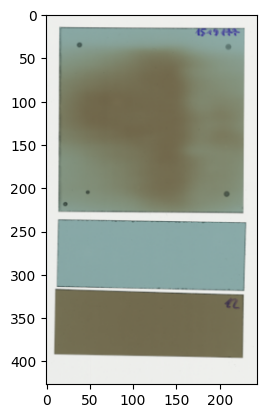

In [219]:
dosymetry_raw = cv2.imread(r'C:\Studia\Magisterka\dosymetry_slicer\Pacjent_Ref1160cGy.tif', cv2.IMREAD_UNCHANGED)
dosymetry_imshow = (dosymetry_raw / 2**8).astype(np.uint8)
plt.imshow(dosymetry_imshow)

In [220]:
stripes_binarized = binarize_stripes(dosymetry_raw, False)

recalibration_stripes_present = True

contours = find_n_contours(stripes_binarized.astype(np.uint8), dosymetry_imshow, 3 if recalibration_stripes_present else 1, False)

labelled_contours = label_contours(dosymetry_imshow, contours)
best_rect = find_maximal_inscribed_rectangle(stripes_binarized, labelled_contours['sample'])
x, y, rw, rh = best_rect


roi_coordinates = {'sample': {'x': x, 'y': y, 'w': rw, 'h': rh}}
if recalibration_stripes_present:
    for name in ['control', 'max_dose']:
        M = cv2.moments(labelled_contours[name])
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        roi_coordinates[name] = {'cx': cx, 'cy':cy}
roi_coordinates

{'sample': {'x': 16, 'y': 17, 'w': 211, 'h': 211},
 'control': {'cx': 121, 'cy': 277},
 'max_dose': {'cx': 117, 'cy': 357}}